In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sn

import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [4]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    
    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [5]:
# Function that returns de key of a given value
# in a dictionary.
def get_key(val):
    for key, value in tag_to_ix.items():
         if val == value:
             return key
 
    return "key doesn't exist"
    
# Function to convert a list of tensors with
# values in a dictionary into a list of its
# respective keys.
def dict_key(data):
    
    return [dict_list(w) for w in data]


# Function to convert a tensor with values in a dictionary
# into a list of its respective keys.
def dict_list(lista):
    
    return [get_key(w) for w in lista]


In [6]:
# Extracts only the labels of the dataset, when the data is in the form: (token,pos,label)
# Returns a list of labels with the same structure as the dataset
def sent2labels(sent):
    return [label for token, postag, label in sent]

# Extracts only the tokens of the dataset, when the data is in the form: (token,pos,label)
# Returns a list of tokens with the same structure as the dataset
def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [7]:
# Function to create a dictionaty containing every word in the dataset
# Returns the generated dictionary
def word_dict(data):
    word_to_ix = {}
    
    for sentence in (data):
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    
    return word_to_ix
        

In [8]:
# Prepares the data to be used in the algorithm, converts every
# word into a feature and separates the labels from the data.
# Data format used: [[(token,postag,label),...],[...]]
def prepareDataLSTMCrF(train_data, test_data):
     
    X_train = [sent2tokens(s) for s in train_data]
    y_train = [sent2labels(s) for s in train_data]

    X_test = [sent2tokens(s) for s in test_data]
    y_test = [sent2labels(s) for s in test_data]
    
    training = list(zip(X_train, y_train))
    test = list(zip(X_test, y_test))
    
    word_to_ix = word_dict(X_train + X_test)
    
    return training,test,word_to_ix
     

In [9]:
# Function that receives the parameters to send to the algorithm
# as well as the data that will be used to train the model.
# It recieves tha training and test data, the dictionary for
# words and tags, the dimensions, learning rate, the weight decay
# and the epochs

def trainLSTMCrF(training_data,test_data,word_to_ix,tag_to_ix,hidden_dim,embedding_dim,lr,weight_decay,epochs):
    
    
    loss_array = []
    acc_array = []
    model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, embedding_dim, hidden_dim)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
        # Check predictions before training
    with torch.no_grad():
        precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
        precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long)
        print(model(precheck_sent))

    # Make sure prepare_sequence from earlier in the LSTM section is loaded
    for epoch in range(epochs):  # again, normally you would NOT do 300 epochs, it is toy data
        
        print(epoch)
        
        running_loss=0

        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is,
            # turn them into Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

            # Step 3. Run our forward pass.
            loss = model.neg_log_likelihood(sentence_in, targets)

            # Step 4. Compute the loss, gradients, and update the parameters by
            # calling optimizer.step()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        
        loss_array.append(running_loss/len(training_data)) #stores the loss of every epoch


    # Check predictions after training
    with torch.no_grad():
        precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
        print(model(precheck_sent))
    # We got it!
    
    return model,loss_array, acc_array


In [10]:
# Generates a heatmap graph with the data provided.
# 'true_values' corresponds to the real labels of the data,
# 'pred' are the labels predicted by the model and 'values'
# are all the possible labels.
def heatmapGraph(true_values,pred,values):
    
    cm = confusion_matrix(true_values,pred, labels=values)
    ax= plt.subplot()
    sn.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
       
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Real Values")
        
    ax.xaxis.set_ticklabels(values)
    ax.yaxis.set_ticklabels(values)
    return
    
    

In [11]:
# Function that runs the model with the test data, it receives
# the model, the data: features with its corresponding tag (data)
# and the word dictionary. It also generates the classification report
# and calls the heatmap graph function.
def testLSTMCrF(data,model,word_to_ix):
    
    predictions = []
    real = []
    y_preds = []
    
    for test_data in data:
        
        with torch.no_grad():
          inputs = prepare_sequence(test_data[0], word_to_ix)
          tag_scores = model(inputs)
        
        pred_result = dict_list(tag_scores[1])
        predictions.extend(pred_result) 
        y_preds.append(pred_result)
        real.extend(test_data[1])
        
    print(classification_report(real,predictions, digits=4))
    heatmapGraph(real,predictions, ['B','I','O'])
    
    return y_preds


In [12]:
# Function to test a single example and predict
# the tags with the sent model
def test_examples(test_data,model,word_to_ix):
    
   with torch.no_grad():
      inputs = prepare_sequence(test_data, word_to_ix)
      tag_scores = model(inputs)
    
   print("FRASE") 
   print("La frase original", test_data)    
   print("La frase original preprocesada", inputs)
   print("Valores máximos e índices", dict_list(tag_scores[1]))
    

**Algorithm sources**

https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html

https://androidkt.com/calculate-total-loss-and-accuracy-at-every-epoch-and-plot-using-matplotlib-in-pytorch/

**Testing the algorithm with the data**

d:\program files\python\python 3.8.6\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-13-04daacb0963c>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  datos = datos.groupby('sequence')['token','pos','ner_tag'].agg(list)


(tensor(46.0926), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
(tensor(172.9061), [2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2])
              precision    recall  f1-score   support

           B     0.9633    0.9789    0.9710      4261
           I     0.8908    0.8908    0.8908       348
           O     0.9943    0.9912    0.9928     22137

    accuracy                         0.9880     26746
   macro avg     0.9495    0.9536    0.9515     26746
weighted avg     0.9880    0.9880    0.9880     26746



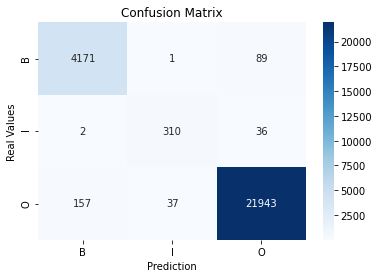

In [13]:
datos = pd.read_csv("data/atta_specimen_ner.csv",keep_default_na=False, na_values=[''])

datos = datos.groupby('sequence')['token','pos','ner_tag'].agg(list)


tokenList = datos['token'].tolist()
posList = datos['pos'].tolist()
tagList = datos['ner_tag'].tolist()

dataList = []
for x,y,z in zip(tokenList,posList,tagList):
    dataList.append(list(zip(x,y,z)))
    
trainData, testData = train_test_split(dataList, test_size=0.2,random_state = 42)

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {"B": 0,"I": 1,"O": 2,
             START_TAG: 3, STOP_TAG: 4}

training_data,test_data,word_to_ix = prepareDataLSTMCrF(trainData,testData)

model,loss,acc = trainLSTMCrF(training_data,test_data,word_to_ix,tag_to_ix,4,5,0.01,1e-4,20)

y_preds = testLSTMCrF(test_data,model,word_to_ix)



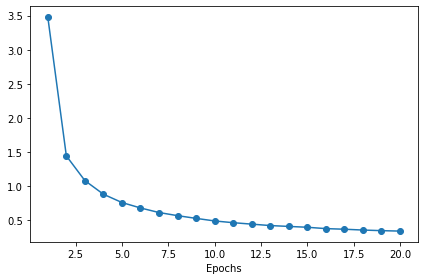

In [52]:
# Graph of accuracy of the model through its epochs.

plt.plot(range(1, len(loss) + 1), loss, marker='o')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [ ]:
# For to print the sentences in which there were errors, its printed as 
# (token,real label, predicted label)

for i in range(len(test_data)):
    if test_data[i][1] != y_preds[i]:
        
        print("Sentence:")
        print(list(zip(test_data[i][0],test_data[i][1],y_preds[i])))